In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkit as nk
from pygsp import graphs as gsp_graphs
import seaborn as sns
import itertools 
import random

from graspy.models import DCSBMEstimator
#import graspy # no module from hyppo._utils import gaussian in latent_distribution_test.py only available in version 0.1.3
# https://github.com/neurodata/hyppo/tree/v0.1.3

**Vertex Partitioning**: The set of vertices in the graph is partitioned into 
$k$ distinct groups or blocks. Each vertex belongs to exactly one block.

**Block Probability Matrix**: The connectivity between nodes is determined by a 
$k×k$ symmetric probability matrix $P$, where each entry $P_{ij}$
represents the probability of an edge between a node in block iand a node in block $j$.

**Edge Independence**: The presence or absence of edges between any two nodes is independent of other edges in the graph, conditional on the block memberships of the nodes. )

**Homogeneity within Blocks**: Nodes within the same block are statistically indistinguishable in terms of their connection probabilities to other nodes (both within and across blocks).

**Flexibility in Block Interactions**: The model can represent various types of block interactions, such as *assortative mixing* (high probability of connections within blocks), *disassortative mixing* (high probability of connections between blocks), or any pattern in between.

**Parameterization**: The model is typically parameterized by the block assignment vector and the block probability matrix. These parameters can be estimated from data using methods like maximum likelihood estimation or Bayesian inference.

**Multigraphs**: Two or more edges that connect the same pair of vertices. These are sometimes used to represent multiple relationships or interactions between the same entities.
The adjacency matrix for a multigraph is conventionally defined such that Aij is equal to the number of edges
between vertices i and j when i =/= j,

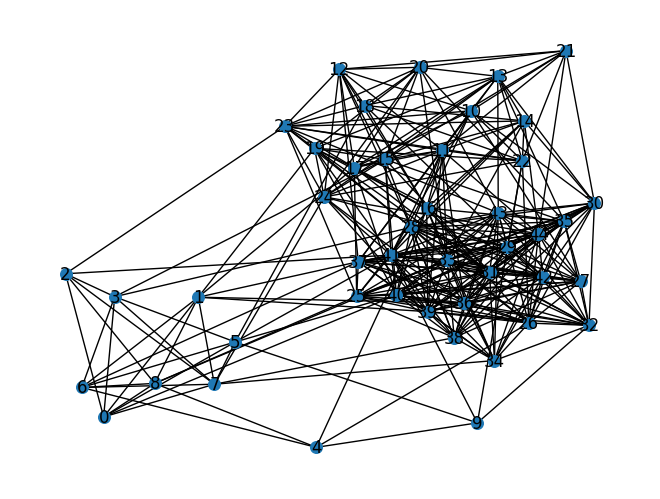

In [7]:
block_sizes = [10, 15, 20]  # Sizes of three blocks
p_matrix = [
    [ .7,  .1, .05],  # Probabilities of links within block 1, between 1-2, and 1-3
    [ .1,  .6, .15],  # Probabilities of links between 2-1, within block 2, and 2-3
    [.05, .15,  .8 ]  # Probabilities of links between 3-1, 3-2, and within block 3
]

G = nx.stochastic_block_model(block_sizes, p_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=70, with_labels=False)
plt.show()

**SBM Algorithm**

In [ ]:
def sbm(sizes, p):
    """
    :param sizes:  [7, 5, 10]
    :param p: [[0.25, 0.05, 0.02],
               [0.05, 0.35, 0.07],
               [0.02, 0.07, 0.40]]
    :return:
    """
    nodelist = range(sum(sizes))

    g = nx.Graph()
    size_cumsum = [sum(sizes[:x]) for x in range(len(sizes) + 1)] # [0,7,12,22]
    partition = [set(nodelist[size_cumsum[x]:size_cumsum[x + 1]]) for x in range(len(size_cumsum) - 1)]
    # block 1 = {0,1,2,...,6},block 2 = {7,8,...,11}, block 3 = {12,13,...,21}

    for block_id, nodes in enumerate(partition):
        for node in nodes:
            g.add_node(node, block=block_id)
    # So far, only empty graph has been generated with block id's(all nodes)

    for i, j in itertools.combinations_with_replacement(range(len(sizes)), 2): 
        # loop over p-matrix: (all row-col combinations of the upper triangular part)
        edges = itertools.combinations(partition[i], 2) if i == j \
            else itertools.product(partition[i], partition[j]) # generate all edgecobination between block i and j (for i==j and i=/=j)
        for e in edges:
            if random.random() < p[i][j]: # random unif(0,1) flag 
                g.add_edge(*e)

    return g

While SBM is useful for modeling community structure with uniform connectivity within blocks, it is not
well-suited for networks where nodes in the same community might have vastly different degrees. This can lead to
inaccuracies in modeling real-world networks where degree variation is common.
Nodes are assigned to blocks as before, but each node $i$ also gets an additional parameter $θ_i$,
which scales the number of edges connecting it to other nodes

#### Degree-Corrected Stochastic Block Model (DCSBM)

1. **Heterogeneity within Blocks**:
   - DCSBM introduces a degree parameter for each node, allowing nodes within the same block to have different expected degrees. This model accommodates the degree variations observed in many real networks.

2. **Connection Probability**:
   - In DCSBM, the probability of an edge between two nodes $i$ and $j$ is not only influenced by their block memberships but also by their individual degree parameters $θ_i$ and $θ_j$. The edge probability is modeled as $θ_i θ_j P_{ij}$, where $P_{ij}$ is still a block-level probability but scaled by the degree parameters of the nodes involved.

3. **Applications**:
   - DCSBM is particularly useful for networks where nodes in the same community or block have different levels of connectivity. It is more flexible in capturing the structure of networks with power-law degree distributions, which are common in social and biological networks.


In [5]:
from graspy.embed import AdjacencySpectralEmbed
from graspy.models import DCSBMEstimator, EREstimator, SBMEstimator
from graspy.models.sbm import _block_to_full, _get_block_indices
from graspy.simulations import er_np, sbm

In [ ]:
# Erdos Reyni
p = 0.3
n = 200

er_graph = er_np(n, p)
er_model = EREstimator(directed=False, loops=False)
er_model.fit(er_graph)

#er_model.p_mat_[er_model.p_mat_ != 0] = p

In [24]:
# SBM
B = np.array([[0.5, 0.1],
              [0.1, 0.3]])
community_sizes = [n // 2, n // 2]

sbm_graph, labels = sbm(community_sizes, B, return_labels=True, loops=False)

sbm_model = SBMEstimator(directed=False, loops=False)
sbm_model.fit(sbm_graph, y=labels) # Estimates B 
sbm_model.block_p_ = B
_, _, _block_inv = _get_block_indices(labels)
sbm_model.p_mat_ = _block_to_full(B, _block_inv, sbm_graph.shape) # Adjacency Matrix 

In [41]:
# DC-SBM
degree_corrections = np.random.beta(2, 2, size=n) # theta with a distribution between 0 and 1 
for label in np.unique(labels): # one label per block, here 2 
    mask = (labels == label)
    degree_corrections[mask] = np.sort(degree_corrections[mask])[::-1] # sort in increasing order 
    comm_sum = np.sum(degree_corrections[mask])
    degree_corrections[mask] = degree_corrections[mask] / comm_sum # Block-wise-normalize 

# Sorting the degree corrections in descending order within each community ensures that nodes with higher degree corrections have relatively higher connectivity compared to those with lower degree corrections. This step is significant for the following reasons:
#Sorting helps maintain a consistent degree distribution within each community, ensuring that nodes expected to have higher connectivity (based on the Beta distribution) are indeed more connected.
#Sorting provides enhanced control over the degree distribution within each community, allowing for a more structured and predictable adjustment of node degrees, which can be useful for modeling specific network structures or testing hypotheses about network behavior.

dcsbm_graph = sbm(community_sizes, B, dc=degree_corrections, loops=False)
# super hacky way of getting DCSBM P matrix
dcsbm_model = DCSBMEstimator(directed=False, loops=False)
dcsbm_model.fit(dcsbm_graph, y=labels)
dcsbm_model.block_p_ = B * (n // 2) ** 2  # block_p_ has a different meaning here
degree_corrections = degree_corrections.reshape(-1, 1)
dcsbm_model.degree_corrections_ = degree_corrections
p_mat = _block_to_full(dcsbm_model.block_p_, _block_inv, dcsbm_graph.shape)
p_mat = p_mat * np.outer(degree_corrections[:, 0], degree_corrections[:, -1])
dcsbm_model.p_mat_ = p_mat
graphs = [er_graph, sbm_graph, dcsbm_graph]
p_mats = [er_model.p_mat_, sbm_model.p_mat_, dcsbm_model.p_mat_]
model_names = ["ER", "SBM", "DCSBM"]

**DC-SBM Algorithm**

In [57]:
def dcsbm(sizes:list, p:np.array, degree_corrections:list):
    """
    Generates a degree-corrected stochastic block model (DCSBM).
    For each edge, the connection probability is adjusted by multiplying the block probability p[i][j] with the product of the degree corrections for the nodes involved in the edge.
    This adjustment ensures that nodes with higher correction factors have higher probabilities of forming connections, consistent with the Degree-Corrected SBM model.

    :param sizes: List of community sizes, e.g., [7, 5, 10]
    :param p: Block probability matrix, e.g., [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
    :param degree_corrections: Degree correction factors for each node
    :return: A networkx graph representing the DCSBM
    """
    nodelist = range(sum(sizes))

    g = nx.Graph()
    size_cumsum = [sum(sizes[:x]) for x in range(len(sizes) + 1)]  # [0, 7, 12, 22]
    partition = [set(nodelist[size_cumsum[x]:size_cumsum[x + 1]]) for x in range(len(size_cumsum) - 1)]
    # block 1 = {0, 1, 2, ..., 6}, block 2 = {7, 8, ..., 11}, block 3 = {12, 13, ..., 21}

    # Add nodes with block ids
    for block_id, nodes in enumerate(partition):
        for node in nodes:
            g.add_node(node, block=block_id)

    # Generate edges with degree corrections
    for i, j in itertools.combinations_with_replacement(range(len(sizes)), 2):  # loop over p-matrix
        edges = itertools.combinations(partition[i], 2) if i == j \
            else itertools.product(partition[i], partition[j])  # generate all edge combinations
        for e in edges:
            node_u, node_v = e
            correction_factor = degree_corrections[node_u] * degree_corrections[node_v]
            if random.random() < p[i][j] * correction_factor:  # apply degree correction factor
                g.add_edge(*e)

    return g

# Example usage:
sizes = [70, 50, 100]
p = [[.5, .05, .02],
     [.05, .5, .03],
     [.02, .03,  .5]]

def generate_theta(n, labels, d_min=2, d_max=100, alpha=2.5, normalize=True):
    """
    :param n: number of nodes 
    :param labels: block labels (important for coloring)
    :param d_min: 
    :param d_max: 
    :param alpha: exponent for powerlaw distribution (the higher, the better distinguishable) 
    :param normalize: 
    :return: 
    """
    #degree_corrections = np.random.beta(2, 2, size=sum(sizes))  # Generate degree corrections
    degree_corrections = np.random.uniform(d_min, d_max, n) ** (-1/alpha)
    
    if normalize:
        # Block-wise correction (optional): 
        for label in np.unique(labels): # one label per block, here 2 
            mask = (labels == label)
            degree_corrections[mask] = np.sort(degree_corrections[mask])[::-1] # sort in increasing order 
            comm_sum = np.sum(degree_corrections[mask])
            degree_corrections[mask] = degree_corrections[mask] / comm_sum # Block-wise-normalize 
            
    return degree_corrections

labels = np.concatenate([np.full(n, i) for i, n in enumerate(sizes)])
theta = generate_theta(sum(sizes), labels, normalize=False)

g = dcsbm(sizes, p, theta)

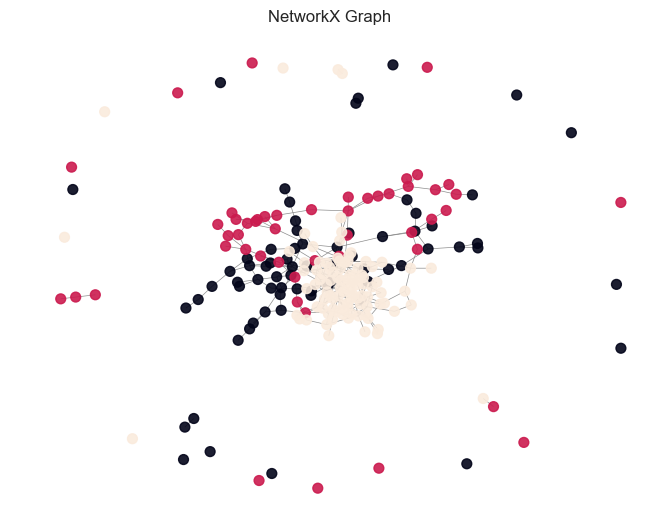

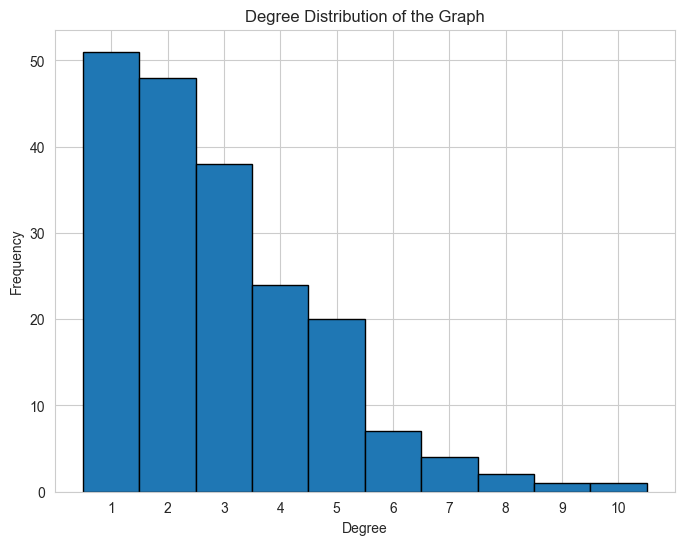

In [58]:
nx.draw(g, with_labels=False,
        node_color=labels,
        edge_color='gray', node_size=50,
        width=.5, 
        alpha=.9)
plt.title('NetworkX Graph')

degrees = [g.degree(n) for n in g.nodes()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=range(1, max(degrees)+2), edgecolor='black', align='left')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.xticks(range(1, max(degrees)+1))
plt.grid(True)
plt.show()

**ADC-SBM Algorithm**